**Professor J. Morlier**

Example from 	
Journal Club for February 2020: Machine Learning in Mechanics: simple resources, examples & opportunities

**How to choose a ML Algorithm?**

Neural Networks (NNs) in their non-Bayesian formulation: the quintessential ML algorithm, based on millions of combinations of simple transfer functions connecting neurons (nodes) that depend on weights. Training involves finding this vast amount of weights such that they fit the data accordingly. Neural networks are very simple algorithms, so they are extremely scalable (they can easily deal with millions of data points). However, as you can imagine, training is not a trivial process because of the overwhelming possibilities for finding the weights of every connection.

Gaussian Processes (GPs): a Bayesian or probabilistic ML algorithm, meaning that it predicts the response as well as the uncertainty. This algorithm has outstanding regression capabilities and, in general, is easy to train. Unfortunately, this algorithm is poorly scalable, so it is limited to small datasets (approximately 10,000 points).

Your goal: study of the approximation of the function $x*sin(x)$ using 8 points in the learning database.

Compare GP (SMT) with NN and polynomial regressioon. Conclude

In [1]:

pip install smt

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: tsfresh 0.18.0 has a non-standard dependency specifier matrixprofile>=1.1.10<2.0.0. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of tsfresh or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
#
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
#
#
from smt.utils import compute_rms_error

from smt.problems import Sphere, NdimRobotArm, Rosenbrock
from smt.sampling_methods import LHS
from smt.surrogate_models import LS, QP, KPLS, KRG, KPLSK, GEKPLS, MGP
try:
    from smt.surrogate_models import IDW, RBF, RMTC, RMTB
    compiled_available = True
except:
    compiled_available = False

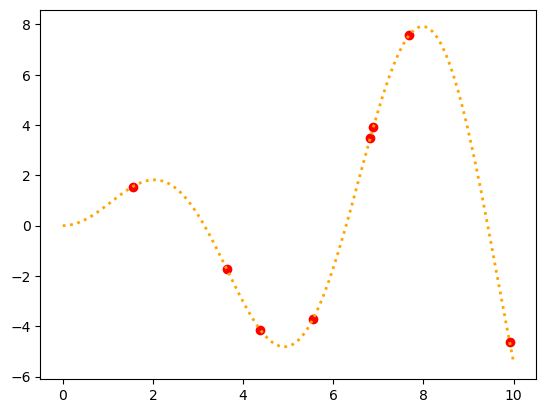

In [3]:
def f(x):
    """ function to approximate by polynomial interpolation"""
    return x * np.sin(x)

seed = 1234 # set a random seed to replicate results
np.random.seed(seed)


#
use_KERAS = 1 # = 1 -> Also use a Neural Network estimator (requires KERAS)
gridsearch = 0 # Do you want to look for the best parameters for the Neural Network? (slower)
#
#
n_train_points = 8 # number of training points (use at least 6)
n_test_points = 20 # number of test points

# generate points used to plot
x_plot = np.linspace(0, 10, 1000)

# generate points and keep a subset of them
x = np.linspace(0, 10, 1000)
rng = np.random.RandomState(seed)
rng.shuffle(x)

x_train = np.sort(x[:n_train_points])
x_test = np.sort(x[n_train_points+1:n_train_points+n_test_points+1])
# Calculate the y values for train and test sets:
y_train = f(x_train) # training data


y_test = f(x_test) # test data (unseen)


# create matrix versions of these arrays
X_train = x_train[:, np.newaxis]
X_test = x_test[:, np.newaxis]
X_plot = x_plot[:, np.newaxis]

fig, axs = plt.subplots(1)
# Plot training points

plt.plot(x_train, y_train, 'ro', markersize=6, label="training points")
plt.plot(x_plot, f(x_plot),  color='orange', linewidth=2, linestyle=':', label="ground truth")


# Plot test points

#plt.plot(x_test, y_test, 'kx', markersize=6, label="testing points")
plt.show()


### Key concepts behind Gaussian Processes

Let's have a quick introduction to the topic by considering the problem of regression of one-dimensional functions (input $X$ and output $Y$). We will follow Görtler et al. (2019) but with a different notation: https://distill.pub/2019/visual-exploration-gaussian-processes

* In Gaussian Processes **each** OUTPUT value $Y_i$ in the training data is treated as a random variable that follows a Gaussian distribution:

    $\mathbf{Y} = \begin{bmatrix}Y_1\\ Y_2 \\ \vdots\\ Y_n \end{bmatrix} \sim \mathcal{N}(\boldsymbol{\mu} , \boldsymbol{\Sigma})$

    and where the joint distribution of all the output values $\mathbf{Y}$ is also Gaussian (a multivariate Gaussian) defined by a mean vector $\boldsymbol{\mu}$ and a covariance matrix $\boldsymbol{\Sigma}$. The mean is usually assumed to be zero.


* Before considering how to calculate $\boldsymbol{\Sigma}$, just look at **Figure 1** of the article that is showing a two-dimensional Gaussian centered around the means $(\mu_1,\,\mu_2)$ and whose shape is controlled by the covariance matrix $\boldsymbol{\Sigma}$. Note that if we change the covariance matrix $\boldsymbol{\Sigma}$, the multivariate Gaussian distribution also changes... Let's play with it a bit: https://distill.pub/2019/visual-exploration-gaussian-processes/#Multivariate


* Formally, the expression for the covariance matrix depends on the "covariance function" or "kernel" $k$ that is calculated for **each** pair of INPUT points $X_i$ and $X_j$:

    $\Sigma_{ij} = \text{Cov}(Y_i,Y_j) = k(X_i,X_j)+\alpha_i^2 \delta_{ij}  \quad \Rightarrow \quad \boldsymbol{\Sigma} = \mathbf{K} + \mathbf{R} $

    where the kernel $k(X_i,X_j)$ can be many different kinds of functions (with some special properties) and $\alpha_i^2$ is the noise level of $Y_i$.


* An example of a kernel function is the RBF: $k(X_i,X_j) = {\color{red}\eta}^2\exp{\left(-\frac{||X_i-X_j||^2}{2{\color{red}\lambda}^2}\right)}$


* Every kernel function has a set of unknown parameters (in red) that are called **hyperparameters**. The RBF has 2 hyperparameters. You can visualize different kernel functions in this figure: https://distill.pub/2019/visual-exploration-gaussian-processes/#MultipleKernels


* In the Gaussian Process method, we start by **assuming** a kernel function with an **initial guess** for the values of the hyperparameters. This defines our **prior** information in conjunction with the assumption that the variables follow a multivariate Gaussian distribution:

    $\begin{bmatrix}\mathbf{Y}\\ Y^* \end{bmatrix} \sim \mathcal{N}\left(\mathbf{0} , \, \begin{bmatrix}\mathbf{K}+\mathbf{R} & \mathbf{k}_*\\ \mathbf{k}_*^T & k(X^*,X^* \end{bmatrix}\right)$


* Multivariate Gaussian distributions have very interesting properties and it turns out that based on the above assumptions a Gaussian Process predicts both the **mean** and the **variance** of the output point $Y^*$ by the following matrix operations:

    $\text{mean}[Y^*]=\mathbf{k}_*^T\left(\mathbf{K}+\mathbf{R}\right)^{-1}\mathbf{Y}$

    $\text{Cov}[Y^*]=k(X^*,X^*)-\mathbf{k}_*^T\left(\mathbf{K}+\mathbf{R}\right)^{-1}\mathbf{k}_*$


* The <span style="color:red">**key concept**</span> is that the prediction of the mean and variance of the new point $Y^*$ depends on the values of the hyperparameters of the kernel function (which are **UNKNOWN**).

### Prior Distribution

The first contact with the concept of prior distribution is a bit strange.

* Prior distribution is just the multivariate Gaussian distribution obtained for a particular choice of kernel function **before** even considering ANY training data.

* Conceptually, it represents the distribution of functions that will be used in the regression process to obtain the **posterior** distribution

* There is a beautiful interactive figure about this here: https://distill.pub/2019/visual-exploration-gaussian-processes/#Prior


### Posterior distribution

* This is the distribution of functions that we obtain by using the training data to **constrain** the set of functions that pass through the training points

* Here's another interactive figure: https://distill.pub/2019/visual-exploration-gaussian-processes/#Posterior


### A short word about kernel "engineering"

As we can see, the choice of kernel affects the type of functions used in the fitting process. For example, the RBF kernel is infinitely smooth, so the approximation obtained from a Gaussian Process using RBF will be infinitely differentiable. This may not be adequate for specific applications...

In addition, we can also combine different kernels by multiplying or adding different basic kernels (RBF with Linear kernel, for example).

* As mentioned in the beginning of this notebook, Duvenaud (2014) has elaborated on this topic significantly in his PhD thesis. He also has a website with a short "cookbook" for kernel engineering: https://www.cs.toronto.edu/~duvenaud/cookbook/

In your assignment, you will explore the influence that the choice of kernel has in the quality of the approximations.

Using Scikit-learn and SMT for Gaussian Process Regression (noiseless and noisy datasets)

In [ ]:
from smt.surrogate_models import KRG

#sm = KRG(theta0=[1e-2], poly='constant', corr='squar_exp')
sm = KRG(theta0=[1e-2], poly='constant', corr='matern52')
sm.set_training_values(x_train, y_train)
sm.train()


y_pred = sm.predict_values(x_plot)
# estimated variance
s2 = sm.predict_variances(x_plot)

fig, axs = plt.subplots(1)

# add a plot with variance
axs.plot(x_train, y_train, "ro")
axs.plot(x_plot, y_pred)
axs.plot(x_plot, f(x_plot))
axs.fill_between(
    np.ravel(x_plot),
    np.ravel(y_pred - 3 * np.sqrt(s2)),
    np.ravel(y_pred + 3 * np.sqrt(s2)),
    color="lightgrey",
)
axs.set_xlabel("x")
axs.set_ylabel("y")
axs.legend(
    ["Training data", "Prediction","ground truth: $f(x) = x\,\sin(x)$","Confidence Interval 99%"],
    loc="lower right",
)


# Prediction of the validation points
y = sm.predict_values(x_test)
#print('LS,  err: '+str(compute_rms_error(y,x_test,y_test)))

# Plot prediction/true values

fig = plt.figure()
plt.plot(y_test, y_test, '-', label='$y_{true}$')
plt.plot(y_test, y, 'r.', label='$\hat{y}$')
       
plt.xlabel('$y_{true}$')
plt.ylabel('$\hat{y}$')
        
plt.legend(loc='upper left')
#plt.title('LS model: validation of the prediction model')


from sklearn.metrics import mean_squared_error, r2_score


# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y))
# Explained variance score: 1 is perfect prediction
print('Variance score (R2): %.2f' % r2_score(y_test, y))




Let's go back with simple method

___________________________________________________________________________
   
                                    LS
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 8
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0000000
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1000
   
   Predicting ...
   Predicting - done. Time (sec):  0.0079985
   
   Prediction time/pt. (sec) :  0.0000080
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 20
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
Mean squared error: 12.57
Variance score (R2): -0.08


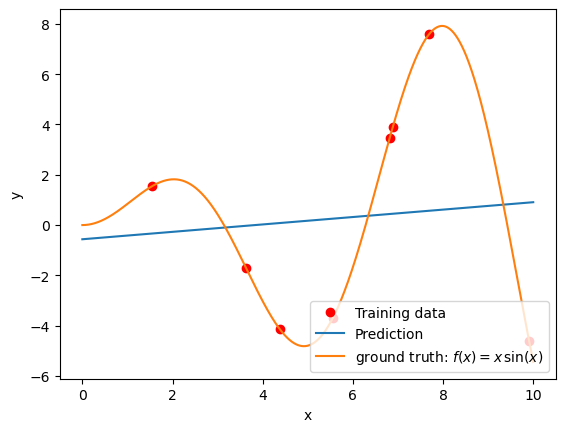

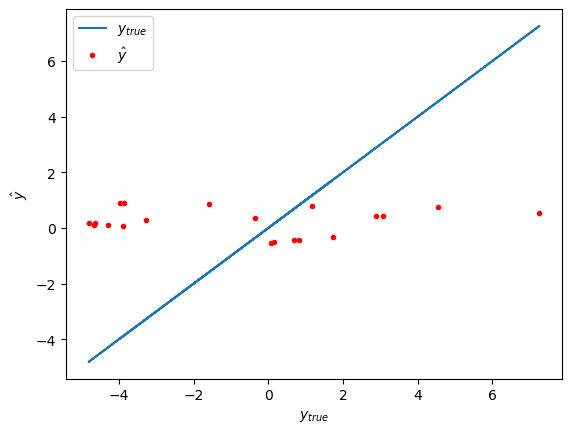

In [6]:
from smt.surrogate_models import LS


sm = LS()
sm.set_training_values(x_train, y_train)
sm.train()


y_pred = sm.predict_values(x_plot)
fig, axs = plt.subplots(1)
# add a plot with variance
axs.plot(x_train, y_train, "ro")
axs.plot(x_plot, y_pred)
axs.plot(x_plot, f(x_plot))

axs.set_xlabel("x")
axs.set_ylabel("y")
axs.legend(
    ["Training data", "Prediction","ground truth: $f(x) = x\,\sin(x)$"],
    loc="lower right",
)

# Prediction of the validation points
y = sm.predict_values(x_test)
#print('LS,  err: '+str(compute_rms_error(y,x_test,y_test)))

# Plot prediction/true values

fig = plt.figure()
plt.plot(y_test, y_test, '-', label='$y_{true}$')
plt.plot(y_test, y, 'r.', label='$\hat{y}$')
       
plt.xlabel('$y_{true}$')
plt.ylabel('$\hat{y}$')
        
plt.legend(loc='upper left')
#plt.title('LS model: validation of the prediction model')

from sklearn.metrics import mean_squared_error, r2_score


# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y))
# Explained variance score: 1 is perfect prediction
print('Variance score (R2): %.2f' % r2_score(y_test, y))



___________________________________________________________________________
   
                                    QP
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 8
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0080113
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1000
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 20
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
Mean squared error: 15.04
Variance score (R2): -0.29


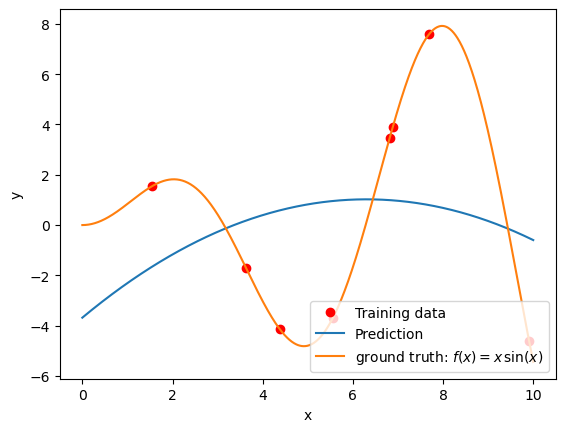

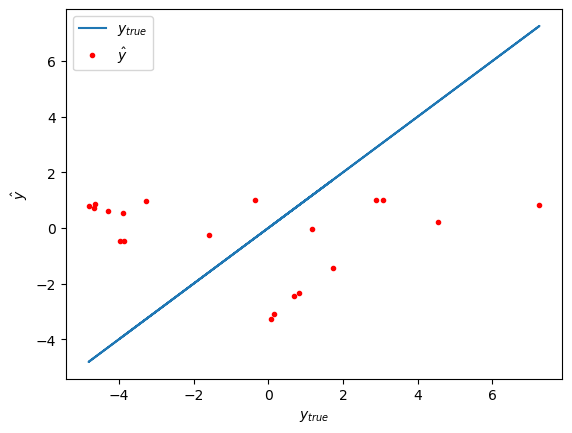

In [7]:
from smt.surrogate_models import QP


sm = QP()
sm.set_training_values(x_train, y_train)
sm.train()


y_pred = sm.predict_values(x_plot)
fig, axs = plt.subplots(1)
# add a plot with variance
axs.plot(x_train, y_train, "ro")
axs.plot(x_plot, y_pred)
axs.plot(x_plot, f(x_plot))

axs.set_xlabel("x")
axs.set_ylabel("y")
axs.legend(
    ["Training data", "Prediction","ground truth: $f(x) = x\,\sin(x)$"],
    loc="lower right",
)

# Prediction of the validation points
y = sm.predict_values(x_test)
#print('LS,  err: '+str(compute_rms_error(y,x_test,y_test)))

# Plot prediction/true values

fig = plt.figure()
plt.plot(y_test, y_test, '-', label='$y_{true}$')
plt.plot(y_test, y, 'r.', label='$\hat{y}$')
       
plt.xlabel('$y_{true}$')
plt.ylabel('$\hat{y}$')
        
plt.legend(loc='upper left')
#plt.title('LS model: validation of the prediction model')

from sklearn.metrics import mean_squared_error, r2_score


# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y))
# Explained variance score: 1 is perfect prediction
print('Variance score (R2): %.2f' % r2_score(y_test, y))

# 3. Introduction to Artificial Neural Networks

This introduction is a selection of materials from the course of Andreas Mueller (Lecture 22): https://github.com/amueller/COMS4995-s19

This is called a multilayer perceptron or fully-connected feed-forward neural network.

* Neurons in hidden layers usually have the same non-linear function (ReLu is popular), weights are different for every neuron.

* Many layers $\rightarrow$ “deep learning”.

* In theory: more hidden layers $\rightarrow$ more complex functions and feature representation. But there's more to this story...

* For regression each output neuron corresponds to a single output variable and the last layer uses a linear activation function.

* ReLu is the most common choice nowadays (easier optimization)

* tanh has small gradients in most places (harder to optimize)

## Quick overview about neural networks

* Non-linear regression models

* Powerful for very large datasets

* Non-convex optimization

* Notoriously slow to train (state of the art models take days or even weeks to train, often on multiple GPUs)

* Important to scale and transform the data properly (preprocessing)

* MANY variants (Convolutional nets, Recurrent neural networks, variational autoencoders, generative adversarial networks, deep reinforcement learning, ...)

## Training Objective

$ h(x) = f(W_1x+b_1) $
$ o(x) = g(W_2h(x)+b_2) = g(W_2f(W_1x + b_1) + b_2)$

$ \min_{W_1,W_2,b_1,b_2} \sum\limits_{i=1}^N l(y_i,o(x_i)) $

$ =\min_{W_1,W_2,b_1,b_2} \sum\limits_{i=1}^N l(y_i,g(W_2f(W_1x+b_1)+b_2)$

- $l$ is the MSE (or squared loss function) for regression.

## Backpropagation

* Need $ \frac{\partial l(y, o)}{\partial W_i} $ and $\frac{\partial l(y, o)}{\partial b_i}$


* Example for network with one hidden layer where $ \text{net}(x) := W_1x + b_1 $

## Optimizing W, b

* Batch

    $ W_i \leftarrow W_i - \eta\sum\limits_{j=1}^N \frac{\partial l(x_j,y_j)}{\partial W_i} $


* Online/Stochastic

    $ W_i \leftarrow W_i - \eta\frac{\partial l(x_j,y_j)}{\partial W_i}$


* Minibatch

    $ W_i \leftarrow W_i - \eta\sum\limits_{j=k}^{k+m} \frac{\partial l(x_j,y_j)}{\partial W_i}$
    

**A nice resource about optimizers** to understand what is learning rate (step size) and momentum: https://distill.pub/2017/momentum/


To note:

1. Standard gradient descent with constant learning rate (or step size) $\eta$ is slow because we update a weight matrix $W_i$ using the old $W_i$ and taking a gradient step after summing over the whole training set.

    * Using the entire training set for each forward pass through the network means that we need to make predictions for every point (without updating the weights) and then do a backward pass with backpropagation... One forward pass and one backward pass is what we call an epoch. So, if we do this, a single epoch has a lot of matrix multiplications to do a single gradient step.
    
    
2. To speed this up we can do a stochastic approximation, i.e. stochastic gradient descent (or online gradient descent). Here, you pick a sample at random, compute the gradient just considering that sample, and then update the parameter. So you update the weights much more often, but you have a much less stable estimate of the gradient. In practice, we often just iterate through the data instead of picking a sample at random. And as with linear models, this is much faster than doing full batches for large datasets.

    * Stochastic grandient descent is less stable (of course!).
    
    
3. A compromise is to consider batch sizes of $k$ samples of the training set (also called mini-batches). For example, we could use 64 points per epoch (one forward and backward pass). In other words: we look at $k=64$ samples, compute the gradients, average them, and update the weights. That allows us to update much more often than looking at the whole dataset, while still having a more stable gradient. This strategy is easy to parallelize in modern CPUs and GPUs and it is very commonly used in practice. The reason why this is faster is basically that doing a matrix-matrix multiplication is faster than doing a bunch of matrix-vector operations.


Finally, a short note: we could also be using smarter optimization methods, like second order methods or LBFGS, but these are often not very effective on these large non-convex problems. One, called levenberg-marquardt is actually a possibility, but it's not really used these days.

# Learning Heuristics

* Constant learning rate $\eta$ not good


* Better: adaptive $\eta$ for each entry of $W_i$ (large $\eta$ in the beginning and small at the end)


* Common approach: adam optimizer


* There are many variants of optimizers... Remember: you will often get different solutions depending on how you pick the learning rate because you are solving a (very) non-convex problem. It's nearly impossible to actually find a global optimum. So nearly all of these strategies are heuristics, that have just proven well to work in practice.

# Complexity Control

These are the main ways to control complexity.

* Decrease number of parameters


* Regularization:

    * L2 & L1 regularization (just like what you did [will do] in the Lab Assignment for Regularized Least Squares)
    * Dropout: randomly prune neurons from the network


* Early Stopping:

    * Early stopping means that you compute the loss from a validation set and then you stop when you start to overfit.

C:\Users\Raul CARREIRA RUFATO\AppData\Local\Temp\ipykernel_22724\1186487313.py:38: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  NN_model = KerasRegressor(build_fn=create_model, neurons1=neurons1, neurons2=neurons2,


Epoch 1/130
1/1 [==============================] - 3s 3s/step - loss: 17.7958 - val_loss: 12.0158
Epoch 2/130
1/1 [==============================] - 0s 100ms/step - loss: 17.7691 - val_loss: 12.0047
Epoch 3/130
1/1 [==============================] - 0s 89ms/step - loss: 17.7457 - val_loss: 11.9951
Epoch 4/130
1/1 [==============================] - 0s 107ms/step - loss: 17.7192 - val_loss: 11.9884
Epoch 5/130
1/1 [==============================] - 0s 108ms/step - loss: 17.7016 - val_loss: 11.9792
Epoch 6/130
1/1 [==============================] - 0s 72ms/step - loss: 17.6860 - val_loss: 11.9690
Epoch 7/130
1/1 [==============================] - 0s 65ms/step - loss: 17.6686 - val_loss: 11.9568
Epoch 8/130
1/1 [==============================] - 0s 81ms/step - loss: 17.6467 - val_loss: 11.9440
Epoch 9/130
1/1 [==============================] - 0s 84ms/step - loss: 17.6242 - val_loss: 11.9303
Epoch 10/130
1/1 [==============================] - 0s 89ms/step - loss: 17.6024 - val_loss: 11.915

1/1 [==============================] - 0s 89ms/step - loss: 11.1505 - val_loss: 7.5040
Epoch 83/130
1/1 [==============================] - 0s 90ms/step - loss: 10.9343 - val_loss: 7.3670
Epoch 84/130
1/1 [==============================] - 0s 99ms/step - loss: 10.7141 - val_loss: 7.2278
Epoch 85/130
1/1 [==============================] - 0s 106ms/step - loss: 10.5000 - val_loss: 7.0909
Epoch 86/130
1/1 [==============================] - 0s 105ms/step - loss: 10.2703 - val_loss: 6.9519
Epoch 87/130
1/1 [==============================] - 0s 91ms/step - loss: 10.0407 - val_loss: 6.8130
Epoch 88/130
1/1 [==============================] - 0s 100ms/step - loss: 9.8084 - val_loss: 6.6763
Epoch 89/130
1/1 [==============================] - 0s 88ms/step - loss: 9.5722 - val_loss: 6.5396
Epoch 90/130
1/1 [==============================] - 0s 87ms/step - loss: 9.3341 - val_loss: 6.4020
Epoch 91/130
1/1 [==============================] - 0s 84ms/step - loss: 9.0986 - val_loss: 6.2622
Epoch 92/130
1

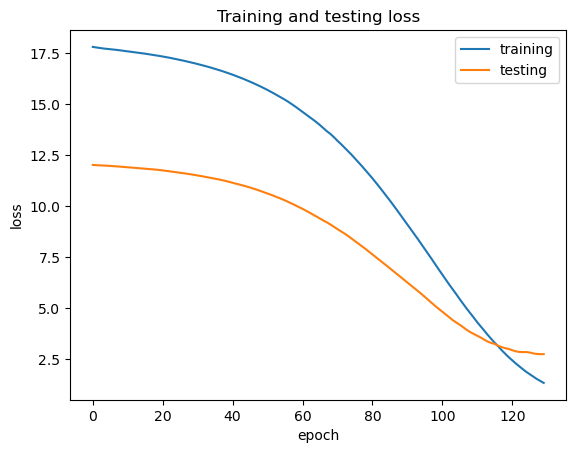

1/1 [==============================] - 0s 54ms/step
Mean squared error: 2.75
Variance score: 0.76


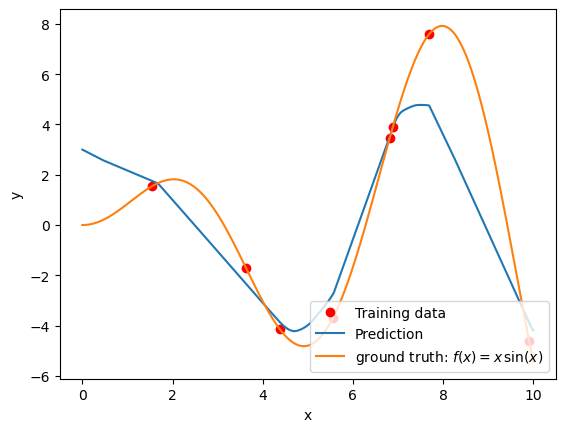

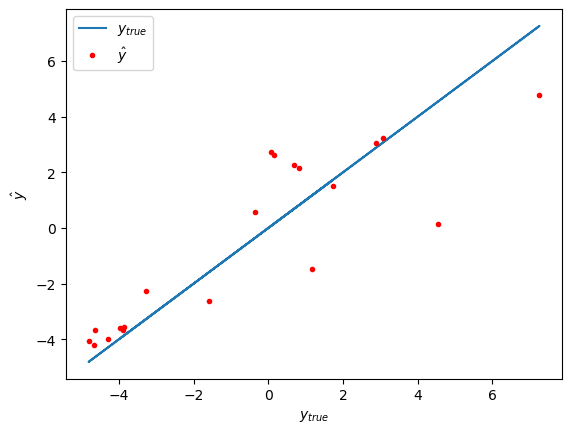

In [4]:

# -----------------------------------------------------------
# Neural Networks example
# KERAS:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
#
# Function to create model, required for KerasClassifier when SPECIFYING INPUTS
def create_model(input_dimensions=1,neurons1=10,neurons2=10,neurons3=10,neurons4=10,activation='relu',optimizer='adam'):
    # create model
    model = Sequential()
    model.add(Dense(neurons1, input_dim=input_dimensions, activation=activation)) # first hidden layer
    model.add(Dense(neurons2, activation=activation)) # second hidden layer
    model.add(Dense(neurons3, activation=activation)) # thrid hidden layer
    model.add(Dense(neurons4, activation=activation)) # fourth hidden layer, etc.
    model.add(Dense(1))
    model.compile(loss='mse', optimizer=optimizer)
    return model
# -----------------------------------------------------------------------------
#

scaler = StandardScaler().fit(X_train)
#
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)
X_plot_scaled=scaler.transform(X_plot)
#


# just use a particular Neural Network of choice
    # Define early stopping:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0, patience=30, mode='min')
neurons1=200
neurons2=10
NN_model = KerasRegressor(build_fn=create_model, neurons1=neurons1, neurons2=neurons2,
                              batch_size=n_train_points, epochs=130, optimizer='adam',
                              callbacks=[early_stopping],
                              validation_data=(scaler.transform(X_test), y_test))
    #
history = NN_model.fit(X_train_scaled, y_train)

#
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and testing loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'testing'], loc='upper right')
plt.show()

# Prediction of the validation points
y_pred = history.model.predict(X_plot_scaled)
fig, axs = plt.subplots(1)
# add a plot with variance
axs.plot(x_train, y_train, "ro")
axs.plot(x_plot, y_pred)
axs.plot(x_plot, f(x_plot))

axs.set_xlabel("x")
axs.set_ylabel("y")
axs.legend(
    ["Training data", "Prediction","ground truth: $f(x) = x\,\sin(x)$"],
    loc="lower right",
)


# Prediction of the validation points
y = history.model.predict(X_test_scaled)
#print('LS,  err: '+str(compute_rms_error(y,x_test,y_test)))

# Plot prediction/true values

fig = plt.figure()
plt.plot(y_test, y_test, '-', label='$y_{true}$')
plt.plot(y_test, y, 'r.', label='$\hat{y}$')
       
plt.xlabel('$y_{true}$')
plt.ylabel('$\hat{y}$')
        
plt.legend(loc='upper left')
#plt.title('LS model: validation of the prediction model')

from sklearn.metrics import mean_squared_error, r2_score


# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y))

Note that this neural network approximation is not brilliant...